In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import random
import argparse
import os
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt

import data
import PtrNet
import metric

## Precision and recall plots 

In [2]:
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

# training_metrics.csv file contains precision, recall and loss values for all epochs
df = pd.read_csv('./results/training_metrics.csv')
x = df['epoch'].tolist()

### Precision

In [3]:
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.plot(x, df['training_precision'])
plt.plot(x, df['validation_precision'])
plt.legend(['Training', 'Validation'])
# plt.savefig('train_precision.eps', format='eps')
plt.show()

### Recall

In [4]:
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.plot(x, df['training_recall'])
plt.plot(x, df['validation_recall'])
plt.legend(['Training', 'Validation'])
# plt.savefig('train_recall.eps', format='eps')
plt.show()

### Loss

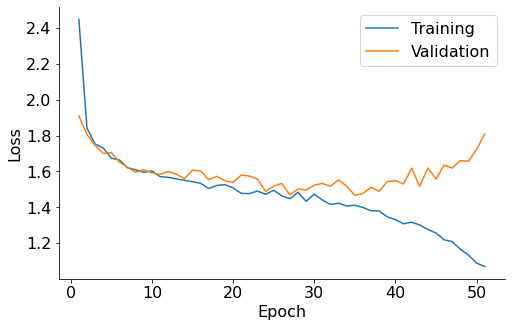

In [5]:
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(x, df['training_loss'])
plt.plot(x, df['validation_loss'])
plt.legend(['Training', 'Validation'])
# plt.savefig('train_loss.eps', format='eps')
plt.show()

# Model evaluation
## Hyperparameters used for training

In [6]:
num_epochs=200
batch_size=256
hidden_size=128
tfr=0.5
wd=1e-5
lr=1e-3
train_data='pineda_balanced_train'
valid_data='pineda_balanced_valid'

## Choose CPU or GPU for eval

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Mercer dataset

In [10]:
test_data='mercer_unique_DS'
test_path = f'./data/{test_data}.csv'
    
model_name = f'ne-{num_epochs}_bs-{batch_size}_hs-{hidden_size}_tfr-{tfr}_wd-{wd}_lr-{lr}_trained-on-{train_data}'
model_path = f'./trained_models/{model_name}/'
    
dataloader_params = {'batch_size': batch_size,
                     'shuffle': True,
                     'num_workers': 8}  
    
test_set = data.RNADataset(rna_file=test_path)
test_generator = DataLoader(test_set, **dataloader_params, collate_fn=data.collate_fn)

mercer_metrics = {'model_type': ['high_precision', 'high_recall'],
                  'test_precision': [],
                  'test_recall': [],
                  'test_precision_pm2': [],
                  'test_recall_pm2': []}
   
beam_width = 4
alpha = 0.7 # Length normalization parameter
for m in ['precision', 'recall']:
    rna_model = torch.load(os.path.join(model_path, f'model_best_{m}.pt'))
    rna_model.eval()
    met = metric.Metric()
    met_pm2 = metric.MetricPM2()
    for batch_idx, (seq, target) in tqdm(enumerate(test_generator)):
        seq, target = seq.to(device), target.to(device)
        best_nodes = rna_model(seq, beam_width=beam_width, alpha=alpha)
        pointer_indices = nn.utils.rnn.pad_sequence(list(map(lambda node : node.to_seq(), best_nodes)))

        met.update(pointer_indices, target)
        met_pm2.update(pointer_indices, target)
        
    mercer_metrics['test_precision'].append(met.precision())
    mercer_metrics['test_recall'].append(met.recall())
    mercer_metrics['test_precision_pm2'].append(met_pm2.precision())
    mercer_metrics['test_recall_pm2'].append(met_pm2.recall())

32it [04:16,  8.01s/it]
32it [04:19,  8.11s/it]


In [11]:
# pd.DataFrame.from_dict(mercer_metrics).to_csv('./results/mercer_results.csv')
pd.DataFrame.from_dict(mercer_metrics)

model_type  test_precision  test_recall  test_precision_pm2  \
0  high_precision        0.639474     0.546937            0.757163   
1     high_recall        0.547660     0.640000            0.686482   

   test_recall_pm2  
0         0.683519  
1         0.779955

## Taggart dataset

In [12]:
test_data='taggart_unique_DS'
test_path = f'./data/{test_data}.csv'
    
model_name = f'ne-{num_epochs}_bs-{batch_size}_hs-{hidden_size}_tfr-{tfr}_wd-{wd}_lr-{lr}_trained-on-{train_data}'
model_path = f'./trained_models/{model_name}/'
    
dataloader_params = {'batch_size': batch_size,
                     'shuffle': True,
                     'num_workers': 8}  
    
test_set = data.RNADataset(rna_file=test_path)
test_generator = DataLoader(test_set, **dataloader_params, collate_fn=data.collate_fn)

taggart_metrics = {'model_type': ['high_precision', 'high_recall'],
                  'test_precision': [],
                  'test_recall': [],
                  'test_precision_pm2': [],
                  'test_recall_pm2': []}
   
beam_width = 4
alpha = 0.7 # Length normalization parameter
for m in ['precision', 'recall']:
    rna_model = torch.load(os.path.join(model_path, f'model_best_{m}.pt'))
    rna_model.eval()
    met = metric.Metric()
    met_pm2 = metric.MetricPM2()
    for batch_idx, (seq, target) in tqdm(enumerate(test_generator)):
        seq, target = seq.to(device), target.to(device)
        best_nodes = rna_model(seq, beam_width=beam_width, alpha=alpha)
        pointer_indices = nn.utils.rnn.pad_sequence(list(map(lambda node : node.to_seq(), best_nodes)))

        met.update(pointer_indices, target)
        met_pm2.update(pointer_indices, target)
        
    taggart_metrics['test_precision'].append(met.precision())
    taggart_metrics['test_recall'].append(met.recall())
    taggart_metrics['test_precision_pm2'].append(met_pm2.precision())
    taggart_metrics['test_recall_pm2'].append(met_pm2.recall())

12it [01:31,  7.60s/it]
12it [01:29,  7.47s/it]


In [13]:
# pd.DataFrame.from_dict(taggart_metrics).to_csv('./results/taggart_results.csv')
pd.DataFrame.from_dict(taggart_metrics)

model_type  test_precision  test_recall  test_precision_pm2  \
0  high_precision        0.255420     0.256637            0.614499   
1     high_recall        0.207683     0.285228            0.546716   

   test_recall_pm2  
0         0.616168  
1         0.698986